In [1]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

In [2]:
matplotlib.rcParams['figure.figsize'] = (10.0, 8.0)

In [3]:
from Preprocessor import Preprocessor
from Registerer import Registerer
import SimpleITK as sitk
import ndreg
import numpy as np

### Step 1: Load data

In [4]:
img = ndreg.imgRead('../forVikram/ailey-dev_thy1eyfp_control_9_upload20170919_ch1_res3.img')
atlas = ndreg.imgRead('../forVikram/average_template_50.tif')

In [5]:
img.SetSpacing((0.04128, 0.04128, 0.04128))

In [6]:
atlas.SetSpacing((0.05, 0.05, 0.05))

### Step 2: initialize Preprocessor class

In [7]:
preprocessor = Preprocessor(img)

### Step 3: remove streaks

In [8]:
new_img = preprocessor.remove_streaks()

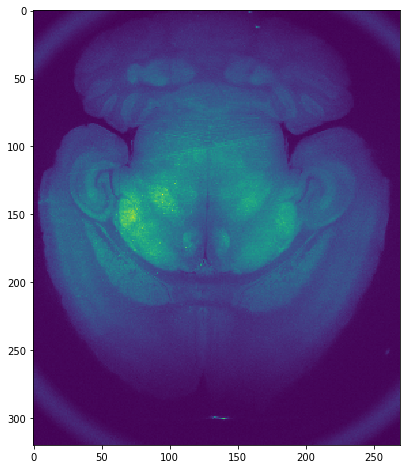

In [9]:
plt.imshow(preprocessor.img_np[80,:,:])
plt.show()

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:1: ComplexWarning: Casting complex values to real discards the imaginary part
  """Entry point for launching an IPython kernel.


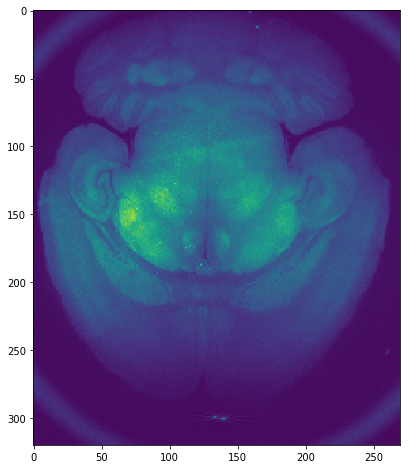

In [10]:
plt.imshow(new_img[80,:,:].astype('float'))
plt.show()

### Step 4: Remove circle

In [11]:
img_no_circle = preprocessor.remove_circle()

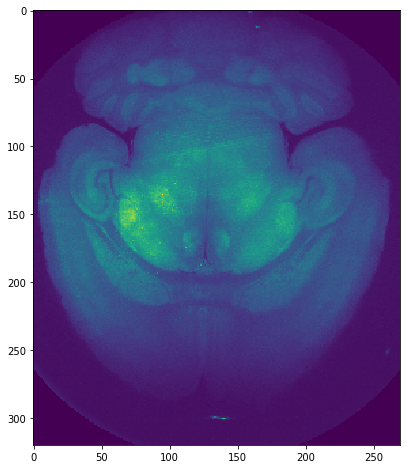

In [12]:
plt.imshow(img_no_circle[80,:,:])
plt.show()

### Step 5: create mask

In [13]:
mask = preprocessor.create_mask()

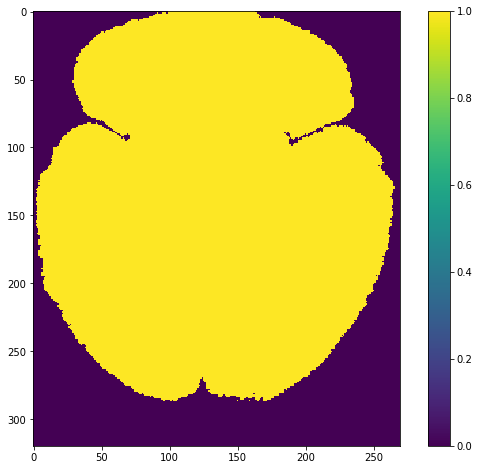

In [14]:
plt.imshow(mask[80,:,:])
plt.colorbar()
plt.show()

### Step 6: Correct Bias field

In [15]:
img_bias_corrected = preprocessor.correct_bias_field(scale=0.25)

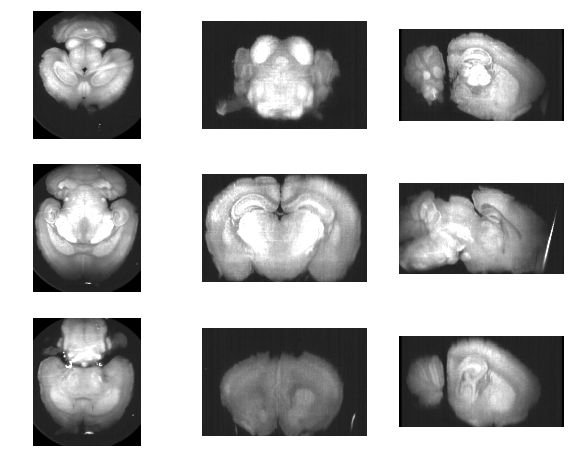

In [16]:
ndreg.imgShow(img_bias_corrected, vmax=1000)

### Do it all at once

In [17]:
img_p = preprocessor.auto_preprocess()

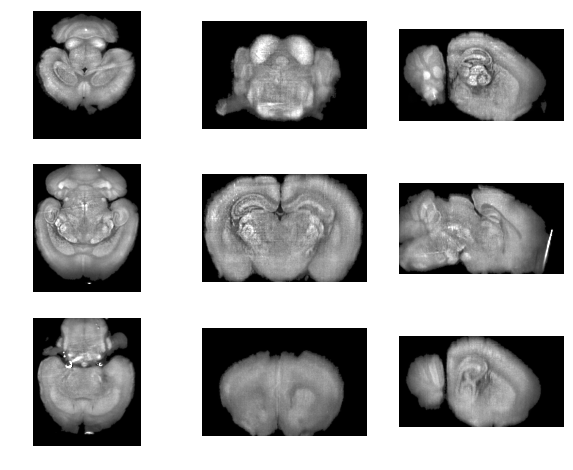

In [18]:
ndreg.imgShow(img_p, vmax=1000)

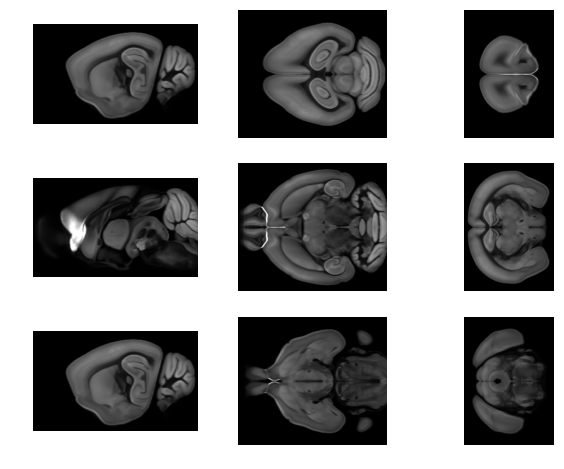

In [19]:
ndreg.imgShow(atlas)

## Registration

In [20]:
registerer = Registerer(atlas, img_p, "ASR", "LPS")

### Perform affine registration

In [21]:
atlas_affine = registerer.register_affine(0.050, iterations=500.0, resolutions=8.0)

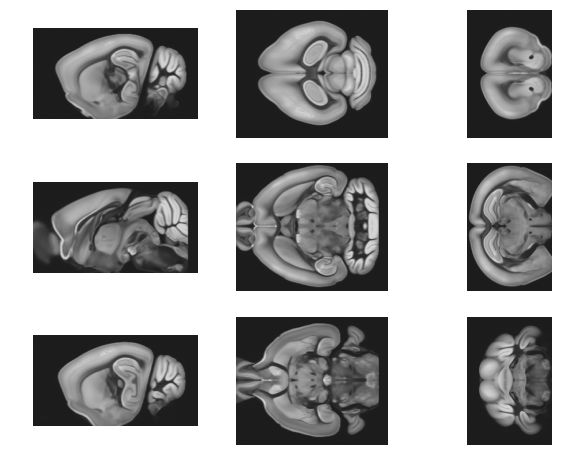

In [22]:
ndreg.imgShow(atlas_affine)

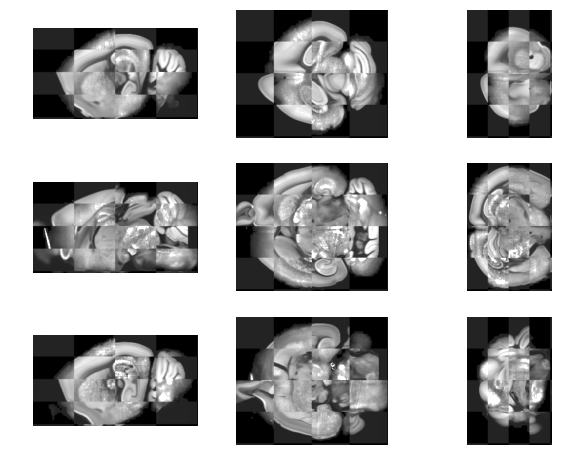

In [23]:
ndreg.imgShow(ndreg.imgChecker(registerer.target_ds, atlas_affine), vmax=1)

In [24]:
mse_affine = registerer.evaluate_affine_registration('../Manual Fiducials/Control9/average_template_10-landmarks.fcsv', 
                                 '../Manual Fiducials/Control9/Control9Auto-landmarks.fcsv', 
                                 0.01/10.0, 0.00516/1.0, "ASL", "RAS")

In [25]:
np.mean(mse_affine)

1.4845595188064384

In [26]:
np.median(mse_affine)

1.4941679883415804

### Perform LDDMM registration


Step 0: alpha=0.1, beta=0.05, scale=0.1
	E, E_velocity, E_rate, E_image (E_image %), LearningRate
0.	3.29669e+11, 480.323, 0, 3.29669e+11 (92.0737%), 3.356934e-09
1.	2.92572e+11, 292.726, 0, 2.92572e+11 (81.7128%), 1.846313e-09
2.	2.9132e+11, 397.913, 0, 2.9132e+11 (81.3632%), 1.015472e-09
3.	2.84696e+11, 482.813, 0, 2.84696e+11 (79.5132%), 1.117020e-09
4.	2.80963e+11, 607.266, 0, 2.80963e+11 (78.4705%), 1.228722e-09
5.	2.7873e+11, 655.089, 0, 2.7873e+11 (77.847%), 3.378984e-10
6.	2.77492e+11, 709.886, 0, 2.77492e+11 (77.5013%), 3.716883e-10
7.	2.75993e+11, 770.636, 0, 2.75993e+11 (77.0826%), 4.088571e-10
8.	2.75015e+11, 839.358, 0, 2.75015e+11 (76.8092%), 4.497428e-10
9.	2.73556e+11, 918.301, 0, 2.73556e+11 (76.4018%), 4.947171e-10
10.	2.72063e+11, 1009.26, 0, 2.72063e+11 (75.9848%), 5.441888e-10
11.	2.71196e+11, 1118.62, 0, 2.71196e+11 (75.7429%), 5.986077e-10
12.	2.69949e+11, 1249.57, 0, 2.69949e+11 (75.3943%), 6.584685e-10
13.	2.69177e+11, 1406.01, 0, 2.69177e+11 (75.1789%), 7.243

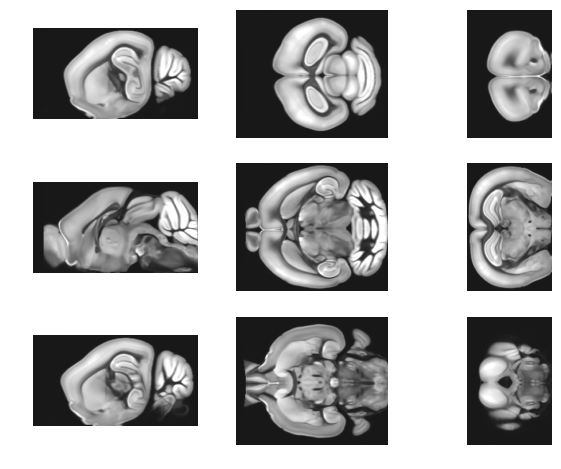

In [27]:
atlas_lddmm = registerer.register_lddmm(alpha_list=[0.1], scale_list = 0.10, 
                                        epsilon_list=1e-4, sigma=1e-5, 
                                        use_mi=False, iterations=400, 
                                        verbose=True)

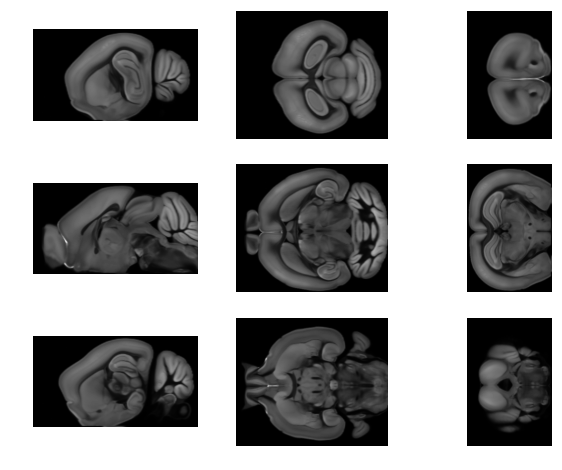

In [28]:
ndreg.imgShow(atlas_lddmm)

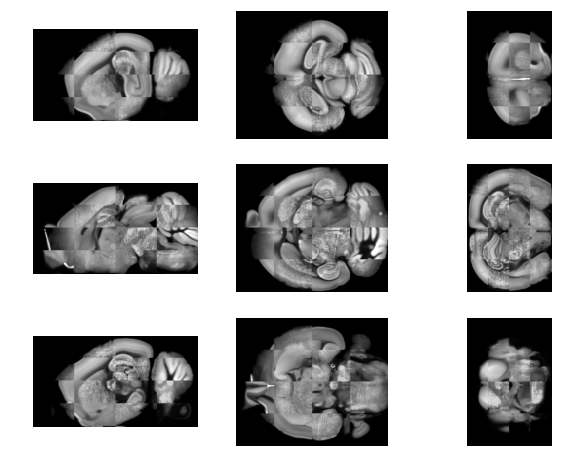

In [29]:
ndreg.imgShow(ndreg.imgChecker(registerer.target_reoriented, atlas_lddmm), vmax=300)

### Evaluate registration

In [30]:
mse_lddmm = registerer.evaluate_lddmm_registration('../Manual Fiducials/Control9/average_template_10-landmarks.fcsv', 
                                                   '../Manual Fiducials/Control9/Control9Auto-landmarks.fcsv', 
                                                   0.01/10.0, 0.00516/1.0, "ASL", "RAS")

In [31]:
np.mean(mse_lddmm)

1.1747796625621145

In [32]:
np.median(mse_lddmm)

1.2486436547666782